# Numerical solutions of a toy ice sheet model 

In week 2 of the ice sheet seminar (Sep 14th) we talked about what causes ice sheets to be concave up, i.e. for the slope to increase as you go down stream. 

We used the depth-integrated mass balance equation

$$
\frac{\partial H}{\partial t} = a - \frac{\partial q}{\partial x},
$$

where $H$ is the ice thickness, $t$ is time, $a$ is the accumulation rate in units of distance per time, $q$ is the depth-integrated ice flux in units of volume (or area if our model ice sheet is 2D) of ice moving past a location per time, and $x$ is distance along flow. 

We also discussed a toy mechanical model for the flux:

$$
q = -H' H.
$$

This notebook investigates this toy model by solving it with two different finite difference schemes, and a flux boundary condition at the left hand side and a fixed ice thickness on the right hand side. 

## Setup

First step is to import some packages. 

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time
from tqdm.notebook import tqdm

Then we setup space and time grids.

In [119]:
#set up time grid
T = 2
Nt = 100000
t = np.linspace(0.0,T, num=Nt)
dt = t[1]-t[0]

#set up space grid
X = 1.0
Nx = 100
x = np.linspace(0.0,X, num=Nx)
dx = x[1]-x[0]

We define some initial conditions for the thickness $H$. Let's use a linear function 

$$ 
H(x,t=0) = 1 - Cx
$$

We also define a constant and uniform accumulation rate $a$. 

In [120]:
H = np.empty((Nx,Nt))

C = 0.7
H[:,0] = 1 - C*x

a = 0.1

Hend = H[-1,0]   # record the value o Hat the right side for use as a boundary condition later.

Plot the initial ice thickness.

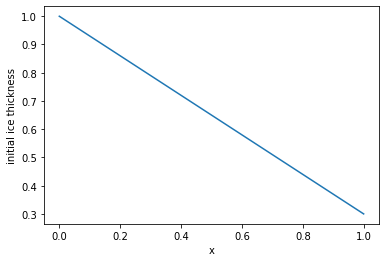

In [121]:
fig, ax = plt.subplots()
ax.plot(x, H[:,0])
plt.xlabel('x')
plt.ylabel('initial ice thickness')
plt.show() 

## Compute gradients 
We will define a function for computing gradients and use it to compute the flux $q$ for this initial $H$. 

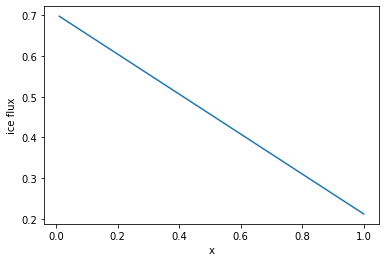

In [122]:
def upwind_diff(f):
    return (f[1:] - f[0:-1])/dx

q = -upwind_diff(H[:,0]) * (H[1:,0] + H[0:-1,0])/2

fig, ax = plt.subplots()
ax.plot(x[1:], q)
plt.xlabel('x')
plt.ylabel('ice flux')
plt.show() 

Notice that the gradient of $q$ (the flux divergence) is uniform to machine precision. 

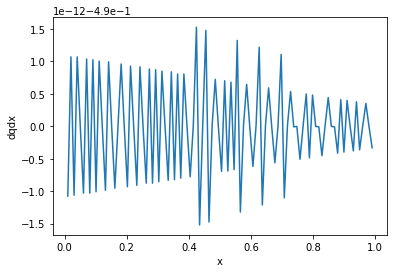

In [123]:
dqdx = upwind_diff(q)
fig, ax = plt.subplots()
ax.plot(x[1:-1], dqdx)
plt.xlabel('x')
plt.ylabel('dqdx')
plt.show()

...so initially $\frac{\partial H}{\partial t}$ will be uniform, except at the boundaries. 

## First version of simulation
Now we run a loop over all the values of $t$, evolving H forward in time according to the mass balance equation. 

This version uses the upwind difference method defined above (in the function upwind_diff).

In [124]:
for i in tqdm(np.arange(Nt-1)):
    q = upwind_diff(H[:,i]) * (H[1:,i] + H[0:-1,i])/2 # compute the flux
    
    dqdx = upwind_diff(q)                             # compute the flux diveregence
    
    H[1:-1,i+1] = H[1:-1,i] + dt*(a + dqdx)           # evolve H
    H[0,i+1] = H[1,i+1]                               # define boundary conditions
    H[-1,i+1] = Hend

    
# save the results in an xarray for easy manipulation and plotting
resultsXR1 = xr.DataArray(data = H, dims = ["x","t"], coords=dict(x=x , t=t),attrs=dict(
        name="Ice Thickness",
        long_name="Ice Thickness"))

Plot a profile of $H$ for every 5000th timestep.

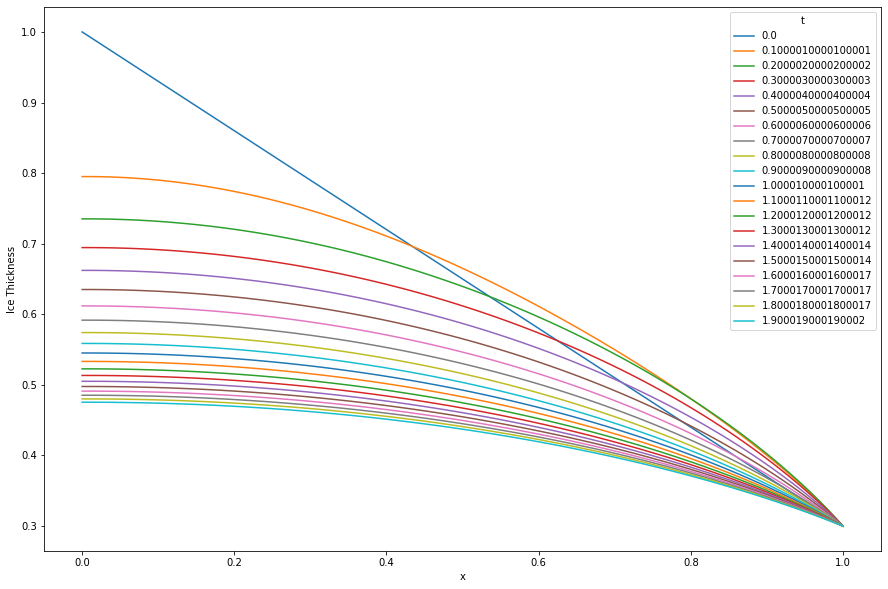

In [127]:
resultsXR1.isel(t=slice(0,-1,5000)).plot.line(hue="t", size=10);

## Theory behind a different finite difference scheme
Interestingly we can also use a slightly different finite difference method if we recognize that 

$$
q = -\frac{\partial H}{\partial x} H = -\frac{1}{2} \frac{\partial H^2}{\partial x}
$$

Therefore  

$$
\frac{\partial q}{\partial x} = -\frac{1}{2} \frac{\partial^2 H^2}{\partial x^2}.
$$

Because we defined our initial $H$ with a simple analytical function $H(x,t=0) = 1 - Cx$ we can compute the initial flux diveregence analytically: 

$$
H^2 = 1 - 2Cx + C^2x^2
$$

so 

$$
\frac{\partial q}{\partial x} =  -C^2.
$$


Let's check this numerically.

First define initial $H$, as before. 

In [128]:
H2 = np.empty((Nx,Nt))

H2[:,0] = 1 - C*x

H2end = H2[-1,0]

#print(f'are q1 and q2 close? {np.allclose(q1,q2)}')

Then let's compute $\frac{\partial q}{\partial x}$ using the method we did before:

In [129]:
q = -upwind_diff(H[:,0]) * (H[1:,0] + H[0:-1,0])/2
dqdx = upwind_diff(q)

print(f"numerically computed dqdx: \n{dqdx}")

print(f"analytically computed dqdx: \n{-(C**2)}")


numerically computed dqdx: 
[-0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49 -0.49
 -0.49 -0.49]
analytically computed dqdx: 
-0.48999999999999994


## A second version of the model
Finally we re-run the simulation using a centered second-order difference of $H^2$, to demonstrate that we get the same results 

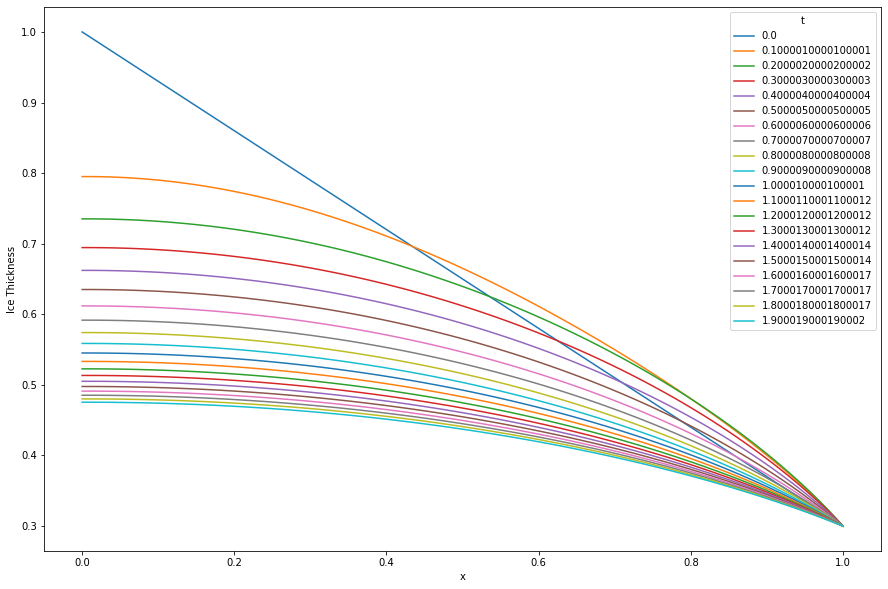

In [131]:

for i in tqdm(np.arange(Nt-1)):
     H2[1:-1,i+1] = H2[1:-1,i] + dt*(a + 0.5* (H2[0:-2,i]**2 - 2*H2[1:-1,i]**2 + H[2:,i]**2)/dx**2)    
     H2[0,i+1] = H2[1,i+1]
     H2[-1,i+1] = Hend
        
resultsXR2 = xr.DataArray(data = H2, dims = ["x","t"], coords=dict(x=x , t=t),attrs=dict(
        name="Ice Thickness",
        long_name="Ice Thickness"))
resultsXR2.isel(t=slice(0,-1,5000)).plot.line(hue="t", size=10);

The two sets of results are numerically the same. 

In [102]:
np.allclose(resultsXR1.values,resultsXR2.values)

True

## Did we reach a steady state?
Lets take a look at the final $q$. It should blanace the climate $a$.

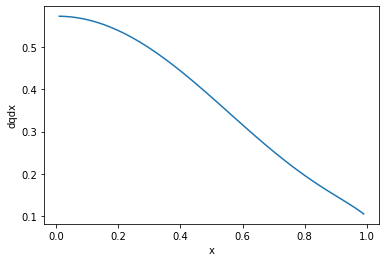

In [105]:
q = -upwind_diff(H[:,-1]) * (H[1:,-1] + H[0:-1,-1])/2
dqdx = upwind_diff(q)
fig, ax = plt.subplots()
ax.plot(x[1:-1], dqdx)
plt.xlabel('x')
plt.ylabel('dqdx')
plt.show()

The flux diveregence should be equal to $a$, but it is not, indicating that the simulation hasnt reached a steady state yet. A longer simulation should eventually reach a steady state. 

## Conclusion

When the initial $H$ is linear, $\dot{H}$ is uniform. It is the boundary conditions which break this uniformity and result in a nonuniform, concave-up profile. 

